In [14]:
# import necessary packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from descartes import PolygonPatch
from tqdm import tqdm

In [15]:
df = pd.read_csv("output/baseline-historical-table.csv",skiprows=6)

In [16]:
#remove all the columns that have the same value in all rows.
for c in df.columns:
    if len(df[c].unique()) < 2:
        df = df.drop(columns=c)

In [17]:
#remove all rows with no data, these are usually the rows at the start of a run.
l = []
for r in df.index:
    if len(df.iloc[r,4:].unique())<2:
        l.append(r)

df = df.drop(index=l)

In [46]:
df.columns

Index(['[run number]', '[step]', 'KPI-homeless', 'KPI-homeless-migrants',
       'KPI-available_buy_houses', 'KPI-available_part_rent_houses',
       'KPI-available_social_rent_houses', 'KPI-avg_income', 'KPI-avg_price',
       'KPI-avg_utility', 'KPI-citizen-count', 'KPI-p-sc-lower',
       'KPI-p-sc-working', 'KPI-p-sc-middle', 'KPI-p-sc-upper', 'KPI-p-dutch',
       'KPI-p-other-western', 'KPI-p-antilles', 'KPI-p-morocco',
       'KPI-p-suriname', 'KPI-p-turkey', 'KPI-p-indonesian',
       'KPI-p-eastern-eu', 'KPI-p-other-nonwestern'],
      dtype='object')

In [20]:
#I found this code to make dict from long list.
def listToDict(lst):
    op = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return op

In [21]:
#This will take two eons of time, please don't run this code unless you really need to.
steps = []
n_steps = 241 
for index, row in tqdm(df.iloc[:n_steps,:].iterrows(), total=n_steps):
    l = []
    for column in df.columns[:4]:
        x = row[column]
        new_df = pd.DataFrame(index=np.arange(0,114), columns=[column])
        new_df[column] = x
        l.append(new_df)
    for column in df.columns[4:]:
        x = row[column].replace("[","").replace("]","").split(" ")
        d = listToDict(x)
        new_df = pd.DataFrame(index=np.arange(0, len(d)), columns=['Neighborhood number', column])
        new_df['Neighborhood number'] = [*d]
        new_df[column] = list(d.values())
        l.append(new_df)
    steps.append(pd.concat(l, axis=1))
full_df = pd.concat(steps).loc[:,~pd.concat(steps).columns.duplicated()].convert_dtypes()

100%|███████████████████████████████████████████████████████████████████████████████▋| 240/241 [00:07<00:00, 32.80it/s]


In [25]:
full_df = full_df.astype(float)

In [63]:
ethn_20 = pd.read_csv("output/ethnicity20.csv").astype(int)

In [64]:
ethn_20['c_total'] = ethn_20[ethn_20.columns[1]] + ethn_20[ethn_20.columns[2]] + ethn_20[ethn_20.columns[3]] + ethn_20[ethn_20.columns[4]] + ethn_20[ethn_20.columns[5]] + ethn_20[ethn_20.columns[6]] + ethn_20[ethn_20.columns[7]] + ethn_20[ethn_20.columns[8]] + ethn_20[ethn_20.columns[9]]

In [65]:
ethn_20['KPI-p-dutch'] = ethn_20['c_dutch'] / ethn_20['c_total']
ethn_20['KPI-p-other-western'] = ethn_20['c_other_western'] / ethn_20['c_total']
ethn_20['KPI-p-antilles'] = ethn_20['c_antilles'] / ethn_20['c_total']
ethn_20['KPI-p-morocco'] = ethn_20['c_morocco'] / ethn_20['c_total']
ethn_20['KPI-p-suriname'] = ethn_20['c_suriname'] / ethn_20['c_total']
ethn_20['KPI-p-turkey'] = ethn_20['c_turkey'] / ethn_20['c_total']
ethn_20['KPI-p-indonesian'] = ethn_20['c_indonesian'] / ethn_20['c_total']
ethn_20['KPI-p-eastern-eu'] = ethn_20['c_eastern_europe'] / ethn_20['c_total']
ethn_20['KPI-p-other-nonwestern'] = ethn_20['c_other_non_western'] / ethn_20['c_total']

In [198]:
ethn_20 = ethn_20.rename(columns={"Buurtcode":"Neighborhood number"}).fillna(0)
ethn_20["Neighborhood number"] = ethn_20["Neighborhood number"].astype(int)

In [199]:
full_df["Neighborhood number"] = full_df["Neighborhood number"].astype(int)

In [200]:
mean_df = full_df[full_df["[step]"]==15].groupby("Neighborhood number").mean().fillna(0)

In [201]:
doubled_df = full_df[full_df["[step]"]==15]
doubled_df["KPI-citizen-count"] = doubled_df["KPI-citizen-count"] * 2.0818254164670784

C:\Users\joche\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [202]:
sum(ethn_20["c_total"]) / sum(doubled_df.groupby("Neighborhood number").mean()["KPI-citizen-count"])

1.0000000000000002

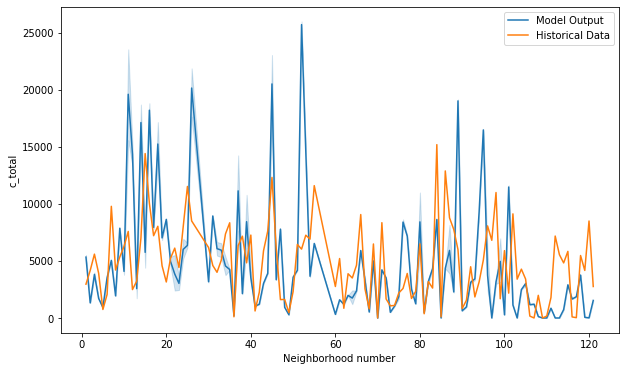

In [203]:
f, ax1 = plt.subplots(figsize=(10,6))
ax1 = sns.lineplot(x="Neighborhood number",y='KPI-citizen-count',data=doubled_df, color="tab:blue",label="Model Output")
#ax2 = ax1.twinx()
ax2 = sns.lineplot(x="Neighborhood number",y="c_total",data=ethn_20, color="tab:orange",label="Historical Data")
plt.legend()
plt.savefig("output/images/validation/ethnicity_total.png")
plt.show()

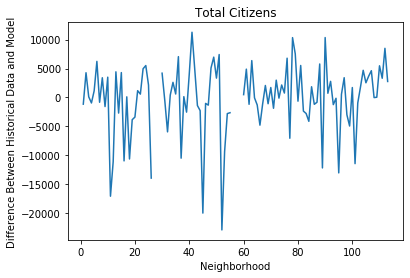

In [204]:
plt.figure()
plt.title("Total Citizens")
plt.plot(ethn_20["c_total"]-doubled_df.groupby("Neighborhood number").mean()["KPI-citizen-count"])
plt.xlabel("Neighborhood")
plt.ylabel("Difference Between Historical Data and Model")
plt.savefig("output/images/validation/ethnicity_diff_total.png")
plt.show()

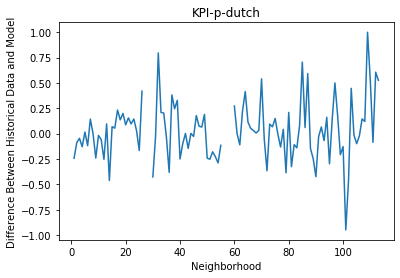

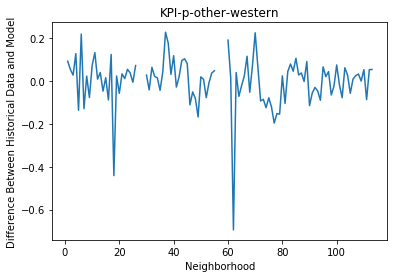

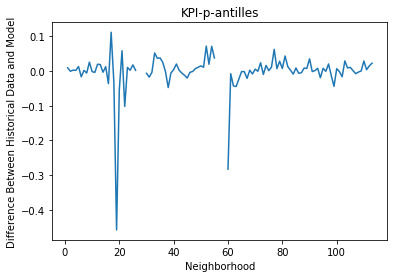

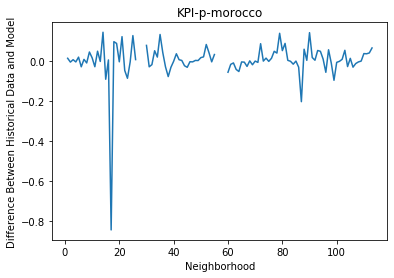

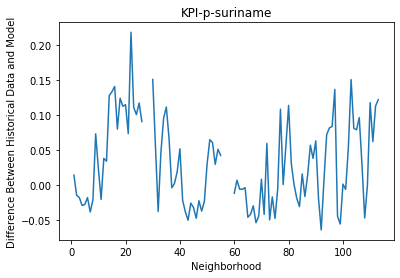

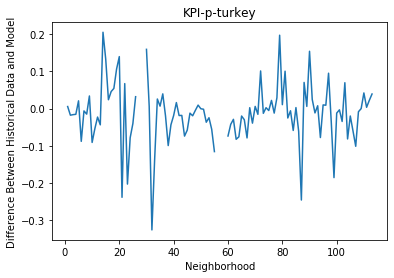

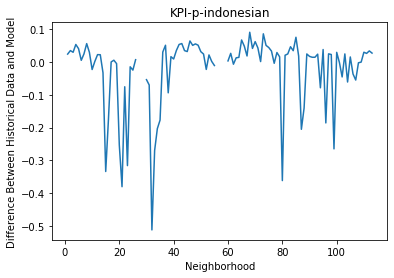

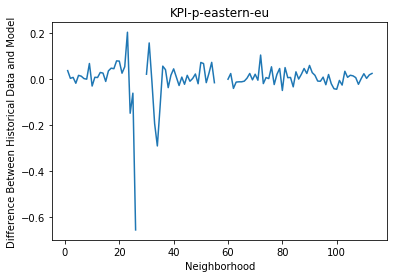

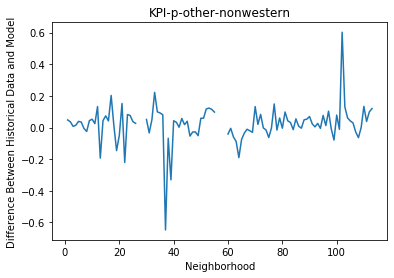

In [205]:
for KPI in ['KPI-p-dutch',
       'KPI-p-other-western', 'KPI-p-antilles', 'KPI-p-morocco',
       'KPI-p-suriname', 'KPI-p-turkey', 'KPI-p-indonesian',
       'KPI-p-eastern-eu', 'KPI-p-other-nonwestern']:
    plt.figure()
    plt.title(KPI)
    plt.plot(ethn_20[KPI]-mean_df[KPI])
    plt.xlabel("Neighborhood")
    plt.ylabel("Difference Between Historical Data and Model")
    plt.savefig("output/images/validation/ethnicity_diff_"+KPI+".png")
    plt.show()

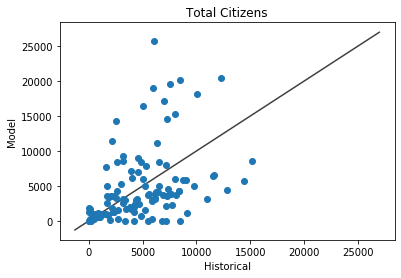

In [206]:
fig, ax = plt.subplots()
plt.title("Total Citizens")
ax.scatter(ethn_20["c_total"],doubled_df.groupby("Neighborhood number").mean()["KPI-citizen-count"])
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel("Historical")
plt.ylabel("Model")
plt.savefig("output/images/validation/ethnicity_scatter_total.png")
plt.show()

In [210]:
print(r2_score(doubled_df.groupby("Neighborhood number").mean()["KPI-citizen-count"], ethn_20["c_total"]))

0.11035846547298911


In [207]:
from sklearn.metrics import r2_score
from scipy import stats
for KPI in ['KPI-p-dutch',
       'KPI-p-other-western', 'KPI-p-antilles', 'KPI-p-morocco',
       'KPI-p-suriname', 'KPI-p-turkey', 'KPI-p-indonesian',
       'KPI-p-eastern-eu', 'KPI-p-other-nonwestern']:
    r2 = r2_score(mean_df[KPI], ethn_20[KPI])
    print(r2)

0.4767417934534257
0.33159005793063157
0.2875951028998399
0.421152693883048
-9.981124755698179
0.25923019543668235
-0.27669734367769294
0.3865811001689814
-0.1740106286069838


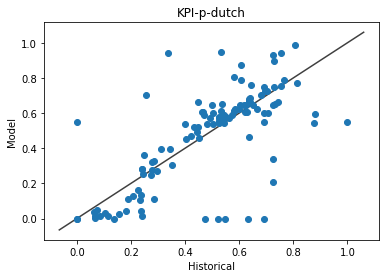

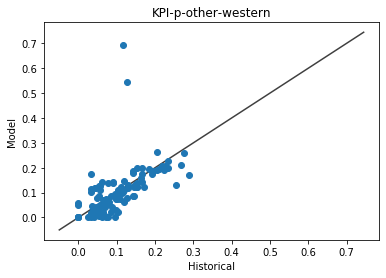

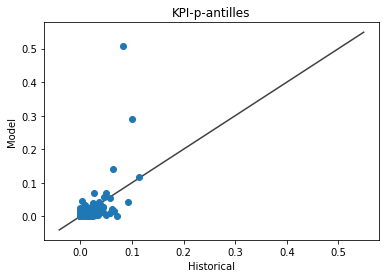

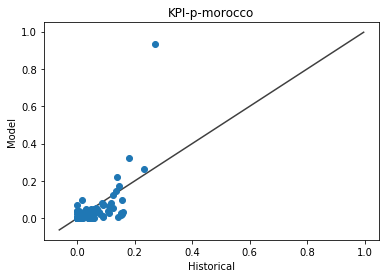

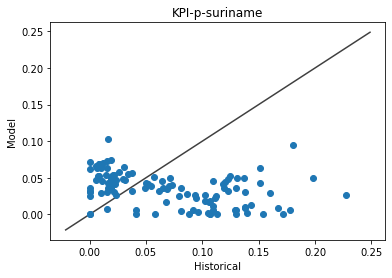

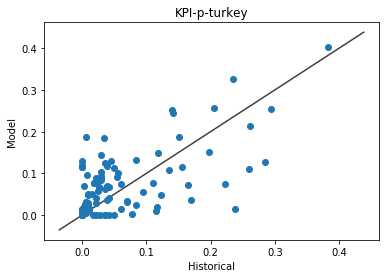

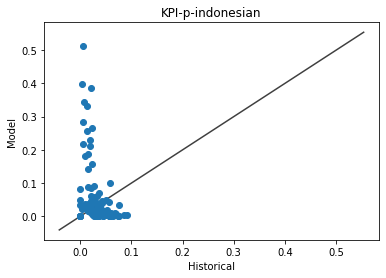

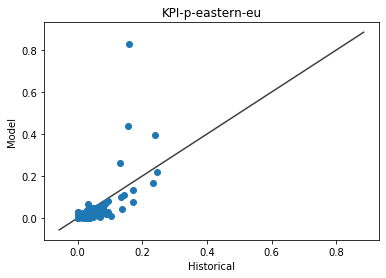

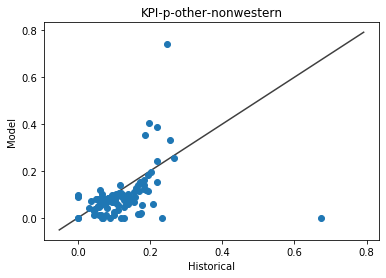

In [208]:
for KPI in ['KPI-p-dutch',
       'KPI-p-other-western', 'KPI-p-antilles', 'KPI-p-morocco',
       'KPI-p-suriname', 'KPI-p-turkey', 'KPI-p-indonesian',
       'KPI-p-eastern-eu', 'KPI-p-other-nonwestern']:
    fig, ax = plt.subplots()
    plt.title(KPI)
    ax.scatter(ethn_20[KPI],mean_df[KPI])
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel("Historical")
    plt.ylabel("Model")
    #plt.savefig("output/images/validation/ethnicity_scatter_"+KPI+".png")
    plt.show()

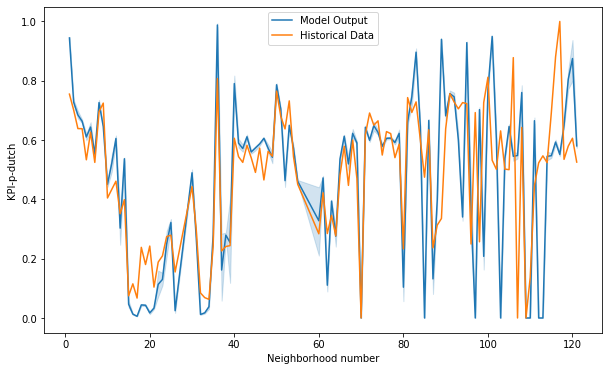

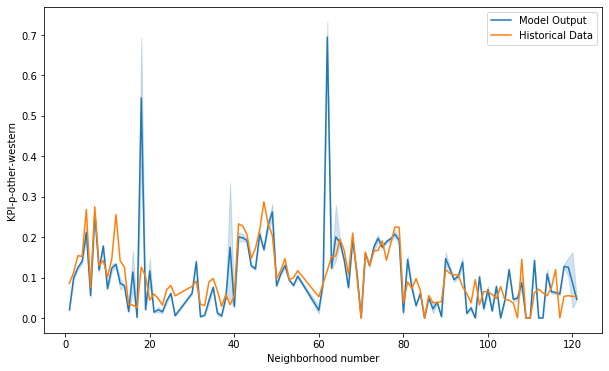

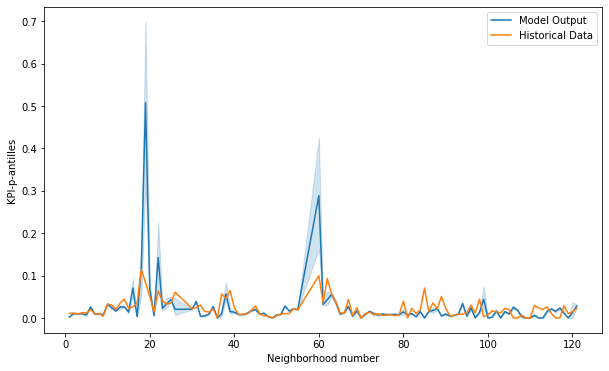

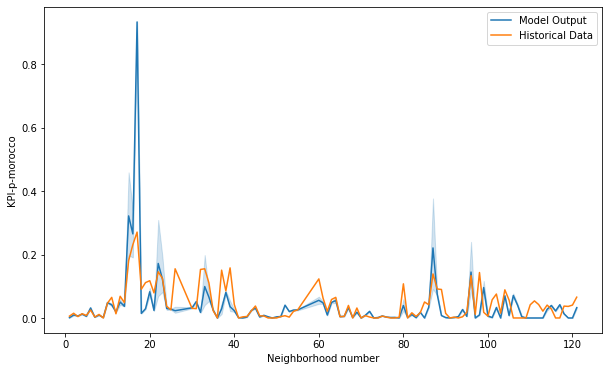

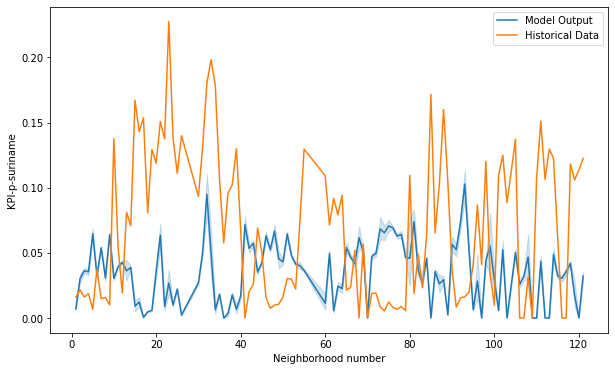

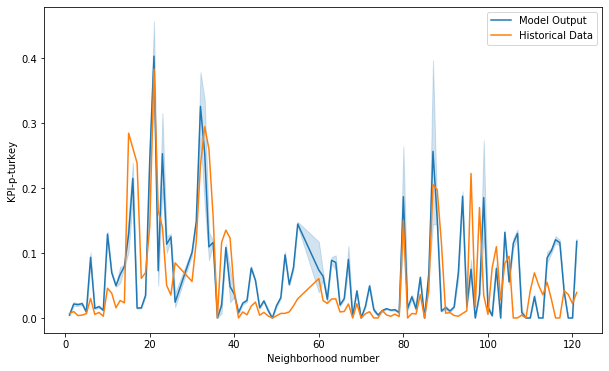

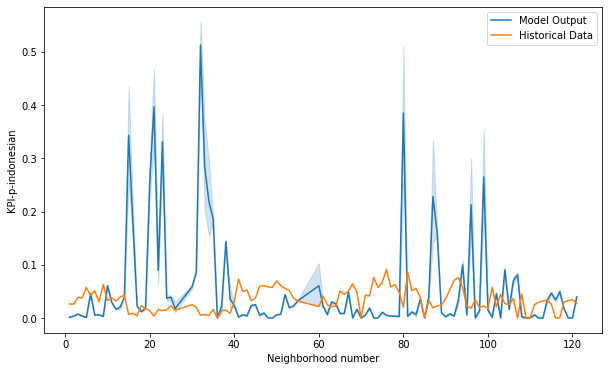

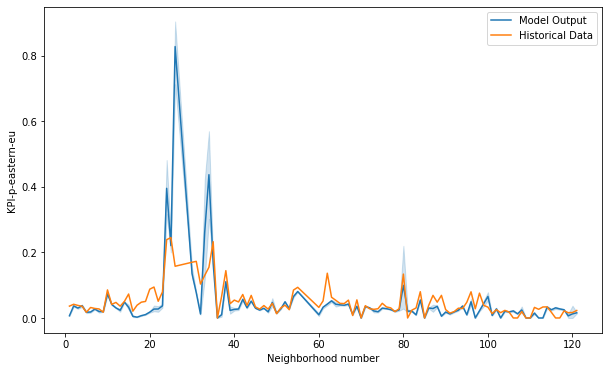

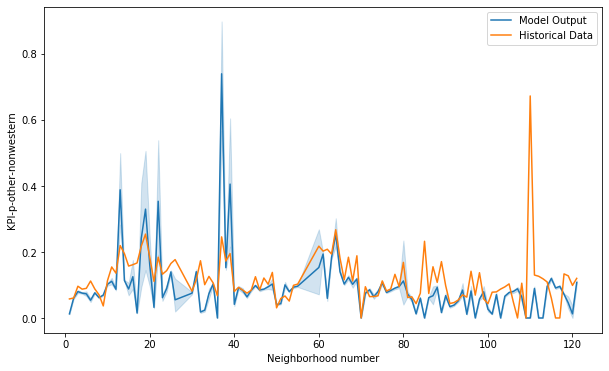

In [209]:
for KPI in ['KPI-p-dutch',
       'KPI-p-other-western', 'KPI-p-antilles', 'KPI-p-morocco',
       'KPI-p-suriname', 'KPI-p-turkey', 'KPI-p-indonesian',
       'KPI-p-eastern-eu', 'KPI-p-other-nonwestern']:
    f, ax1 = plt.subplots(figsize=(10,6))
    ax1 = sns.lineplot(x="Neighborhood number",y=KPI,data=full_df[full_df["[step]"]==15], color="tab:blue",label="Model Output")
    #ax2 = ax1.twinx()
    ax2 = sns.lineplot(x="Neighborhood number",y=KPI,data=ethn_20, color="tab:orange",label="Historical Data")
    plt.legend()
    plt.savefig("output/images/validation/ethnicity_"+KPI+".png")
    plt.show()